In [1]:
import json
import geatpy as ea
from utils import get_png_paths, scan,char_id_mapping, action_id_mapping

In [12]:
import numpy as np
import geatpy as ea
import time
import random
import os

def split_vars(Vars):
    base = np.zeros_like(Vars)
    bias = np.zeros_like(Vars)
    ones = (Vars==1)
    base[ones] = 1
    twos = (Vars == 2)
    bias[twos] = 1
    return base, bias
class CardMatchPop(ea.Population):
    def set_cards(self, cards):
        self.cards = cards
    def set_field(self, lbs,ubs,types):
        self.Field = np.vstack((np.array(lbs),np.array(ubs),np.array(types)))
    def initChrom(self, NIND):
        if NIND is not None:
            self.sizes = NIND  # 重新设置种群规模
        if self.cards is None:
            raise ValueError("cards not initialized")
        var_nums = self.Field.shape[1]
        res = []
        now = time.time()
        for i in range(self.sizes):
            twos = random.randint(0, self.cards//2 - 1)
            t = [2]*twos + [1]*(self.cards-twos) + [0]*(var_nums - self.cards)
            np.random.shuffle(t)
            res.append(t)
        print("init pop cost {}s".format(time.time()-now),flush= True)
        self.Chrom = np.array(res)
        self.Lind = self.Chrom.shape[1]  # 计算染色体的长度
        self.ObjV = None
        self.FitnV = None
        self.CV = None

def BestChars(CharComfort:np.ndarray, selected_char, eles = None, pickp = 0.95):
    """给定一个角色的id,返回他的最佳队友
    eles[char_id] = ele_type
    """
    charnum = CharComfort.shape[0]
    best_pair = (0,0)
    best_scores = float('-inf')
    
    for j in range(charnum):
        if j == selected_char:
            continue
        for k in range(charnum):
            if k == j or k == selected_char:
                continue
            if eles != None:
                if eles[selected_char] == eles[j] == eles[k]:
                    continue
            scores = CharComfort[selected_char,j] + CharComfort[j,k] + CharComfort[selected_char,k]
            if scores > best_scores:
                if random.random()< pickp:
                    best_pair = (j ,k)
                    best_scores = scores
    return best_pair

def BestTeam(CC,eles = None):
    N = CC.shape[0]
    best_team = (0,0,0)
    best_score = float("-inf")
    for i in range(N):
        mate1,mate2 = BestChars(CC,i,eles)
        scores = CC[i,mate1] + CC[i,mate2] + CC[mate1,mate2]
        if scores > best_score:
            best_team = (i, mate1,mate2)
            best_score = scores
    return best_team

def MatchCardGA(comfort,selected_chars, c2a , 
                card_num = 30, ban_list = [],
                try_algo = 3, repeat_bonus = 5, char_bonus = 0.1,
                NIND = 500, ITERS = 300):
    """
    ban_list: 不准使用的卡的id
    """
    print_p = 1e-5
    alpha = repeat_bonus
    cards = card_num
    sigma = 0.82
    N = comfort.shape[0]
    beta = N/len(selected_chars)*(1+char_bonus)
    portion = 0.05
    weight = np.zeros(N)
    for char_idx in selected_chars:
        weight += c2a[char_idx, :].flatten()
    @ea.Problem.single
    def evalVars(Vars):
        #if random.random() < print_p:
        #    print("action cards contribution:{}".format(np.dot(np.dot(Vars,comfort), Vars) ))
        #    print("character preference contribution:{}".format(np.dot(weight,Vars)))
        f = np.dot(np.dot(Vars,comfort), Vars) + beta*np.dot(weight,Vars)
        #base,bias = split_vars(Vars)
        #f = np.dot(np.dot(base, comfort), base)+  \
        #np.dot(np.dot(bias, comfort), bias) + np.dot(weight, Vars)
        #f = np.dot(np.dot(base, comfort), base)+  \
        #0.99*np.dot(np.dot(bias, comfort), base)+0.9*np.dot(np.dot(base,comfort), bias)\
        #+ 0.8*np.dot(np.dot(bias,comfort), bias)\
        #+ beta*np.dot(weight, Vars)
        CV = np.array([np.abs(np.sum(Vars) - cards)])
        return f, CV
    lbs = [0]*N
    ubs = [2]*N
    for i in ban_list:
        ubs[i] = 0
    prob = ea.Problem(
        name = "Card Matching",
        M = 1,
        maxormins = [-1],
        Dim = comfort.shape[0],
        varTypes=[1]*comfort.shape[0],
        lb = lbs,
        ub = ubs,
        evalVars=evalVars
    )
    Pop = CardMatchPop(Encoding='RI',NIND = NIND)
    Pop.set_cards(cards)
    Pop.set_field(lbs,ubs,[1]*N)
    print(type(Pop))
    if try_algo == 0:
        pass
    elif try_algo == 1:
        algorithm = ea.soea_SGA_templet(
            problem = prob,
            population=Pop,
            MAXGEN=ITERS,
            trappedValue=1e-8,
            maxTrappedCount=10,logTras= 0
        )
    elif try_algo == 2:
        algorithm = ea.soea_DE_best_1_bin_templet(
            problem = prob,
            population=Pop,
            MAXGEN=ITERS,
            trappedValue=1e-5,
            maxTrappedCount=10,logTras= 0
        )
    elif try_algo == 3:
        ##最快且解最好.
        algorithm = ea.soea_GGAP_SGA_templet(
            problem = prob,
            population=Pop,
            MAXGEN=ITERS,
            trappedValue=1e-7,
            maxTrappedCount=ITERS//10,
            logTras= 0
        )
    algorithm.mutOper.Parallel = True
    algorithm.recOper.Parallel = True
    #algorithm.mutOper.Parallel = True
    #print(type(Pop))
    #print(type(algorithm.population))
    res = ea.optimize(algorithm,
                      outputMsg=True,drawLog=True,saveFlag=False)
    if res['Vars'] is None:
        return None
    return res['Vars'].flatten()

In [13]:
class Trainer:
    def __init__(self, data_root,
                 act_card_idpath,
                 char_card_idpath,
                 id_actpath,
                 id_charpath,
                 decks_path= 'deck_scan.json',
                 char_eles_path = 'char_eles.json'):
        act_card_idpath = os.path.join(data_root, act_card_idpath)
        char_card_idpath = os.path.join(data_root, char_card_idpath)
        id_actpath = os.path.join(data_root, id_actpath)
        id_charpath = os.path.join(data_root, id_charpath)
        decks_path = os.path.join(data_root, decks_path)
        char_eles_path = os.path.join(data_root, char_eles_path)
        with open(act_card_idpath) as act:
            self.act_id = json.load(act)
        with open(char_card_idpath) as char:
            self.char_id = json.load(char)
        with open(id_actpath) as id_act:
            temp = json.load(id_act)
            self.id_act = {}
            for key in temp.keys():
                self.id_act[int(key)] = temp[key]
        with open(id_charpath) as id_char:
            temp = json.load(id_char)
            self.id_char = {}
            for key in temp.keys():
                self.id_char[int(key)] = temp[key]
        with open(char_eles_path) as ce:
            self.char_eles = json.load(ce)
        self.data_root = data_root
        self.actnum = len(self.act_id)
        self.charnum = len(self.char_id)
        self.CharComfort = None
        self.CharPreferAct = None
        self.ActComfort = None
        self.deckscan_path = decks_path
        ###self.load_pre_scan()
    def norm_matrix(self):
        self.CharComfort = np.zeros_like(self.c2c)
        for i in range(self.c2c.shape[0]):
            if self.cfreq[i] == 0:
                continue
            for j in range(self.c2c.shape[1]):
                if self.cfreq[j] == 0:
                    continue
                self.CharComfort[i,j] = 2*self.c2c[i,j]/(self.cfreq[i]+self.cfreq[j])
        self.CharPreferAct = np.zeros_like(self.c2a)
        for i in range(self.c2a.shape[0]):
            if self.cfreq[i] == 0:
                continue
            for j in range(self.c2a.shape[1]):
                if self.afreq[j] == 0:
                    continue
                self.CharPreferAct[i,j] = 2*self.c2a[i,j]/(self.cfreq[i] + self.afreq[j])
        self.ActComfort = np.zeros_like(self.a2a)
        for i in range(self.a2a.shape[0]):
            if self.afreq[i] == 0:
                continue
            for j in range(self.a2a.shape[1]):
                if self.afreq[i] == 0:
                    continue
                self.ActComfort[i,j] = 2*self.a2a[i,j]/(self.afreq[i]+self.afreq[j])
        #self.CharComfort = self.CharComfort/np.sum(self.CharComfort)
        #self.CharPreferAct /= np.sum(self.CharPreferAct)
        #self.ActComfort /= np.sum(self.ActComfort)
        self.CharComfort /= 100
        self.CharPreferAct /= 100
        self.ActComfort /= 100
    def _check_ele_type(self, card_name):
        if card_name.find('rock') != -1 or card_name.find('stone') != -1:
            return 'geo'
        if card_name.find('flame')!=-1:
            return 'pyro'
        if card_name.find('voltage') != -1 or card_name.find('thunder')!=-1:
            return 'electro'
        if card_name.find('wind')!=-1:
            return 'anemo'
        if card_name.find('ice') !=-1:
            return 'cryo'
        if card_name.find('water') != -1:
            return 'hydro'
        if card_name.find('weeds') != -1 or card_name.find('green')!=-1:
            return 'dendro'
        pass
    def ifpermit(self, chars, card):
        """检查chars和card是否合法.
        chars: 一个长度为3的字典, key=char名, value=char_id
        card: 长度为1的字典, key=card_name ,value=card_id
        """
        char_eles = []
        for char in chars:
            char_eles.append(self.char_eles[char])
        for name in card:
            if name.find("elemental_resonance") != -1:
                ele_type = self._check_ele_type(name)
                if char_eles.count(ele_type) < 2:
                    return False
            if name == "abyssal_summons":
                monsters = ['maguu_kenki','rhodeia_of_loch','stonehide_lawachurl','jadeplume_terrorshroom']
                if len(set(chars.keys()) & set(monsters)) < 2:
                    return False
        return True
    def _update(self, scan_dict):
        chars = scan_dict['characters']
        actions = scan_dict['actions']
        if 'bennett' in chars and 'naganohara_meteor_swarm' in actions:
            actions['grand_expectation'] = actions['naganohara_meteor_swarm']
            actions.pop('naganohara_meteor_swarm', None)
        for char in chars.keys():
            cid = self.char_id[char]
            self.cfreq[cid] += 1
            for pchar in chars.keys():
                if pchar != char:
                    pcid = self.char_id[pchar]
                    self.c2c[cid][pcid] += 1
            for act in actions.keys():
                aid = self.act_id[act]
                #self.c2a[cid][aid] += (actions[act] + 1)/2
                self.c2a[cid][aid] += 1
        for act in actions.keys():
            aid = self.act_id[act]
            #self.afreq[aid] += actions[act]
            self.afreq[aid] += 1
            for pact in actions.keys():
                if pact != act:
                    paid = self.act_id[pact]
                    #self.a2a[aid][paid] += (actions[pact]+actions[act])/2
                    self.a2a[aid][paid] += 1
                #else:
                #   self.a2a[aid][aid] += (actions[act] - 1)/2
            #self.a2a[aid][aid] = self.afreq[aid]
    def load_pre_scan(self):
        with open(self.deckscan_path) as dp:
            self.decks = json.load(dp)
    def abs_data_path(self, path):
        return os.path.join(self.data_root, path)
    def train(self, cfreq_path = 'cfreq.npy',
              afreq_path = 'afreq.npy',
              c2c_path = 'c2c.npy',
             c2a_path = 'c2a.npy',
             a2a_path = 'a2a.npy'):
        """calculate necessary matrix by datasets.
        """
        self.cfreq = np.zeros(self.charnum)
        self.afreq = np.zeros(self.actnum)
        self.c2c = np.zeros((self.charnum, self.charnum))
        self.c2a = np.zeros((self.charnum, self.actnum))
        self.a2a = np.zeros((self.actnum, self.actnum))
        self.load_pre_scan()
        for deck in self.decks:
            self._update(deck)
        self.norm_matrix()
        self.eles = {}
        for char, cid in self.char_id.items():
            self.eles[cid] = self.char_eles[char]
        cfreq_path = self.abs_data_path(cfreq_path)
        afreq_path = self.abs_data_path(afreq_path)
        c2c_path = self.abs_data_path(c2c_path)
        c2a_path = self.abs_data_path(c2a_path)
        a2a_path = self.abs_data_path(a2a_path)
        np.save(cfreq_path, self.cfreq)
        np.save(afreq_path, self.afreq)
        np.save(c2c_path, self.c2c)
        np.save(c2a_path, self.c2a)
        np.save(a2a_path, self.a2a)
        print("train finished")
    def load(self, cfreq_path = 'cfreq.npy',
              afreq_path = 'afreq.npy',
              c2c_path = 'c2c.npy',
             c2a_path = 'c2a.npy',
             a2a_path = 'a2a.npy'):
        """only be used if you have existing data file.
        available after first running train()
        """
        cfreq_path = self.abs_data_path(cfreq_path)
        afreq_path = self.abs_data_path(afreq_path)
        c2c_path = self.abs_data_path(c2c_path)
        c2a_path = self.abs_data_path(c2a_path)
        a2a_path = self.abs_data_path(a2a_path)
        self.cfreq = np.load(cfreq_path)
        self.afreq = np.load(afreq_path)
        self.c2c = np.load(c2c_path)
        self.c2a = np.load(c2a_path)
        self.a2a = np.load(a2a_path)
        self.norm_matrix()
        #self.load_pre_scan()
    def predict3(self, c1,c2, c3,chs_path = None,
                GROUP_SIZE = 500, ITERS= 500,
               try_algo = 3,rb = 5, cb = 3):
        if self.CharComfort is None:
            print("please load data first")
            return None
        cid = self.char_id[c1]
        pal1 = self.char_id[c2]
        pal2 = self.char_id[c3]
        res = {}
        #print(self.id_char)
        res['chars'] = (self.id_char[cid], self.id_char[pal1], self.id_char[pal2])
        chars = {res['chars'][0]:cid, res['chars'][1]:pal1, res['chars'][2]:pal2}
        ban_list = [self.act_id['blank']]
        for card in self.act_id:
            if not self.ifpermit(chars,{card:self.act_id[card]}):
                ban_list.append(self.act_id[card])
        #print([self.id_act[ids] for ids in ban_list])
        cards = MatchCardGA(self.ActComfort, (cid,pal1,pal2),
                            self.CharPreferAct,ban_list = ban_list,char_bonus=cb,
                            try_algo=try_algo, NIND= GROUP_SIZE,ITERS= ITERS,repeat_bonus= rb)
        selected_indices = np.nonzero(cards)[0]
        deck = {}
        #print(selected_indices)
        if chs_path is None:
            for i in range(len(selected_indices)):
                idx = selected_indices[i]
                deck[self.id_act[idx]] = cards[idx]
            res['deck'] = deck
        else:
            chs_path = self.abs_data_path(chs_path)
            with open(chs_path, 'r', encoding='UTF-8') as chs:
                CN = json.load(chs)
            for i in range(len(selected_indices)):
                idx = selected_indices[i]
                deck[CN[self.id_act[idx]]] = cards[idx]
            res['deck'] = deck
        print("推荐卡组:")
        print(res)
        return res
        
    def predict(self, character_name, chs_path = None,
                GROUP_SIZE = 500, ITERS= 500,
               try_algo = 3,rb = 5, cb = 3):
        if self.CharComfort is None:
            print("please load data first")
            return None
        cid = self.char_id[character_name]
        res = {}
        pal1, pal2 = BestChars(self.CharComfort, cid, self.eles)
        #print(self.id_char)
        res['chars'] = (self.id_char[cid], self.id_char[pal1], self.id_char[pal2])
        chars = {res['chars'][0]:cid, res['chars'][1]:pal1, res['chars'][2]:pal2}
        ban_list = [self.act_id['blank']]
        for card in self.act_id:
            if not self.ifpermit(chars,{card:self.act_id[card]}):
                ban_list.append(self.act_id[card])
        #print([self.id_act[ids] for ids in ban_list])
        cards = MatchCardGA(self.ActComfort, (cid,pal1,pal2),
                            self.CharPreferAct,ban_list = ban_list,char_bonus=cb,
                            try_algo=try_algo, NIND= GROUP_SIZE,ITERS= ITERS,repeat_bonus= rb)
        selected_indices = np.nonzero(cards)[0]
        deck = {}
        #print(selected_indices)
        if chs_path is None:
            for i in range(len(selected_indices)):
                idx = selected_indices[i]
                deck[self.id_act[idx]] = cards[idx]
            res['deck'] = deck
        else:
            chs_path = self.abs_data_path(chs_path)
            with open(chs_path, 'r', encoding='UTF-8') as chs:
                CN = json.load(chs)
            for i in range(len(selected_indices)):
                idx = selected_indices[i]
                deck[CN[self.id_act[idx]]] = cards[idx]
            res['deck'] = deck
        print("推荐卡组:")
        print(res)
        return res

In [14]:
if False:
    char_id_mapping()
    action_id_mapping()

In [15]:
from pathlib import Path
abs_path = str(Path("__file__").parent.absolute())
data_root = os.path.join(abs_path,'data')
T = Trainer(data_root, 'action_id.json','char_id.json',
            'id_action.json','id_char.json')

In [16]:
T.train()

train finished


In [17]:
c1,c2,c3 = BestTeam(T.CharComfort, eles = data_root + '/' + 'char_eles.json')
print("best team = {}, {}, {}".format(T.id_char[c1],T.id_char[c2],T.id_char[c3]))

best team = bennett, cyno, fatui_pyro_agent


<class '__main__.CardMatchPop'>
init pop cost 0.034996986389160156s


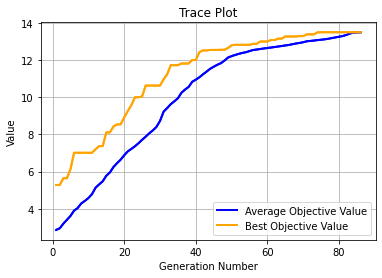

Execution time: 61.37154150009155 s
Evaluation number: 430000
The best objective value is: 13.498164516084133
The best variables are: 
0	2	0	0	0	0	0	0	0	0	0	1	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	2	2	0	0	1	2	0	0	0	0	0	0	2	2	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	2	0	0	2	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	
推荐卡组:
{'chars': ('ganyu', 'diona', 'fischl'), 'deck': {'仙跳墙': 2, '换班': 1, '9爷': 2, '赌徒耳环': 1, '千岩套': 1, '本大爷还没输！': 2, '交给我吧！': 2, '立本': 2, '璃月港': 1, '莲花酥': 2, '蒙德兽肉饼': 2, '蘑菇披萨': 2, '派蒙': 2, '星天之兆': 2, '运筹帷幄': 2, '最好的伙伴!': 2, '提米': 2}}


{'chars': ('ganyu', 'diona', 'fischl'),
 'deck': {'仙跳墙': 2,
  '换班': 1,
  '9爷': 2,
  '赌徒耳环': 1,
  '千岩套': 1,
  '本大爷还没输！': 2,
  '交给我吧！': 2,
  '立本': 2,
  '璃月港': 1,
  '莲花酥': 2,
  '蒙德兽肉饼': 2,
  '蘑菇披萨': 2,
  '派蒙': 2,
  '星天之兆': 2,
  '运筹帷幄': 2,
  '最好的伙伴!': 2,
  '提米': 2}}

In [11]:
T.predict3('ganyu','sucrose','fischl',
           chs_path='action_chs.json',
          cb=-0.1,GROUP_SIZE= 5000)